In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import time
import sys
import os
from multiprocessing import Pool
from functools import partial
directory = 'figures'
if not os.path.exists(directory):
    os.makedirs(directory)
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.notebook import tqdm
import numpy as np
from dask.distributed import Client, progress, LocalCluster
from dask import compute, delayed
import dask.array as da
from dask.diagnostics import ProgressBar
plt.rcParams['figure.dpi']=400

In [2]:
def denseH(L, J, hx, hz, periodic):
    """
    generates the dense Hamiltonian matrix for the quantum Ising chain with both transverse and longitudinal magnetic fields
    
        Parameters:
            L (int): length of chain
            J (float): ising interaction strength
            h (float): magnetic field strength
            periodic (bool): does the chain have periodic boundary conditions?
            
        Returns:
            H (ndarray): 2^L x 2^L matrix representing the Hamiltonian operator
    """

    dim=2 ** L # dimensions of the Hilbert space
    
    H = np.zeros((dim, dim)) # initliaze the Hamiltonian
    
    "Calculation of off-diagonal elements due to the magnetic field"
    
    for beta in range(dim): # iterate over all states
        
        for j in range(1,L+1): # iterate over all sites
            
            alpha = beta ^ (1<<j-1) # flips jth bit of beta to get the state alpha that is related to beta by a single bit flip
            
            H[alpha, beta] -= hx # contribution by sigma^j_x
            
    "Calculation of diagonal elements due to Ising interaction"

    for alpha in range(dim): # iterate over all states
        
        for j in range(1, L): # iterate over all sites
            
            if 2*(alpha & (1 << j-1)) == alpha & (1 << j): # check if site j and j+1 have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
            
        "Diagonal elements due to longitudinal magnetic field"
        
        for j in range(1, L+1):
            
            if alpha & (1 << (j-1)) == 0:  # check if the spin at site j is up
                H[alpha, alpha] -= hz  # decrease energy for spin up
                
            else:
                H[alpha, alpha] += hz  # increase energy for spin down

        
        "Handling case of periodic boundary conditions"
                
        if periodic and L > 1: # L > 1 needed for periodicity to mean anything
            
            if (alpha & (1 << L-1)) == ((alpha & (1 << 0))*(2**(L-1))): # Check if the states at either end have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
                
    return H   

def diagonalize(Ls, J, hx, hz, periodic):
    
    eigss = []
    vecss = []
    
    for L in Ls:
        H = denseH(L, J, hx, hz, periodic)
        eigs, vecs = scipy.linalg.eigh(H)
        eigss.append(eigs)
        vecss.append(vecs)
    
    return eigss, vecss

Ls = [6, 8, 10, 12, 14]
J = 1
hx = -1.05
hz = 0.5
periodic = True 

start_time = time.time()
eigss, vecss = diagonalize(Ls, J, hx, hz, periodic)
end_time = time.time()
print('time taken:', end_time-start_time)

time taken: 283.0728998184204


In [3]:
def translational_operator(state, L):
    translated_state = np.zeros_like(state)
    for i in range(len(state)):
        binary = f'{i:0{L}b}'
        translated_binary = binary[-1] + binary[:-1]
        new_index = int(translated_binary, 2)
        translated_state[new_index] = state[i]
    return translated_state

def filter_k_zero(eigenvalues, eigenvectors, L):
    k_zero_indices = []
    for i, vec in enumerate(eigenvectors.T):
        if np.allclose(vec, translational_operator(vec, L), atol=1e-10):
            k_zero_indices.append(i)
    k_zero_eigenvalues = eigenvalues[k_zero_indices]
    k_zero_eigenvectors = eigenvectors[:, k_zero_indices]
    return k_zero_eigenvalues, k_zero_eigenvectors

def sigma_vec(mu, vec):
    sigma_vec = np.zeros(len(vec), dtype=complex)
    for alpha in range(len(vec)):
        if mu == 'z':
            if alpha & 1:
                sigma_vec[alpha] -= vec[alpha]
            else:
                sigma_vec[alpha] = vec[alpha]
        elif mu == 'y':
            beta = alpha ^ 1
            if alpha & 1:
                sigma_vec[beta] = -1j * vec[alpha]
            else:
                sigma_vec[beta] = 1j * vec[alpha]
        elif mu == 'x':
            beta = alpha ^ (1 << 0)
            sigma_vec[beta] = vec[alpha]
    return sigma_vec

In [4]:
k_zero_data = {}

start_time = time.time()

for i, L in enumerate(Ls):
    eigenvalues, eigenvectors = eigss[i], vecss[i]
    k_zero_eigenvalues, k_zero_eigenvectors = filter_k_zero(eigenvalues, eigenvectors, L)
    k_zero_data[L] = (k_zero_eigenvalues, k_zero_eigenvectors)
    
end_time = time.time()
print('time taken:', end_time-start_time)

time taken: 298.85589814186096


In [ ]:
xkcd_colors = ['xkcd:royal blue', 'xkcd:green', 'xkcd:orange', 'xkcd:hot pink', 'xkcd:indigo']
plt.figure()
for i, L in enumerate(Ls):
    k_zero_eigenvalues, k_zero_eigenvectors = k_zero_data[L]
    energies = k_zero_eigenvalues / L

    observables = []
    for vec in tqdm(k_zero_eigenvectors.T, desc=f"Processing L={L} for sigma^x", leave=True):
        observable = abs(np.dot(vec.conj(), sigma_vec('x', vec)))
        observables.append(observable)

    plt.scatter(energies, observables, label=f'L={L}', color=xkcd_colors[i])

plt.xlabel('$\epsilon_n / L$')
plt.ylabel('$\\langle \\sigma^{x}_1 \\rangle_n$')
plt.legend()
plt.savefig(f'sigmaxpart2.png', dpi=400)
plt.show()

In [ ]:
plt.figure()
for i, L in enumerate(Ls):
    k_zero_eigenvalues, k_zero_eigenvectors = k_zero_data[L]
    energies = k_zero_eigenvalues / L

    observables = []
    for vec in tqdm(k_zero_eigenvectors.T, desc=f"Processing L={L} for sigma^y", leave=True):
        observable = abs(np.dot(vec.conj(), sigma_vec('y', vec)))
        observables.append(observable)

    plt.scatter(energies, observables, label=f'L={L}', color=xkcd_colors[i])

plt.xlabel('$\epsilon_n / L$')
plt.ylabel('$\\langle \\sigma^{y}_1 \\rangle_n$')
plt.legend()
plt.savefig(f'sigmaypart2.png', dpi=400)
plt.show()

In [ ]:
plt.figure()
for i, L in enumerate(Ls):
    k_zero_eigenvalues, k_zero_eigenvectors = k_zero_data[L]
    energies = k_zero_eigenvalues / L

    observables = []
    for vec in tqdm(k_zero_eigenvectors.T, desc=f"Processing L={L} for sigma^z", leave=True):
        observable = abs(np.dot(vec.conj(), sigma_vec('z', vec)))
        observables.append(observable)

    plt.scatter(energies, observables, label=f'L={L}', color=xkcd_colors[i])

plt.xlabel('$\epsilon_n / L$')
plt.ylabel('$\\langle \\sigma^{z}_1 \\rangle_n$')
plt.legend()
plt.savefig(f'sigmazpart2.png', dpi=400)
plt.show()

# Trying to the optional part

In [5]:
def sigma(mu, vecs):
    N = vecs.shape[1]
    sigma_vecs = np.zeros(vecs.shape, dtype=complex)

    for i in range(N):
        vec = vecs[:, i]

        for alpha in range(len(vec)):
            if mu == 'z':
                if alpha & 1:
                    sigma_vecs[alpha, i] -= vec[alpha]
                else:
                    sigma_vecs[alpha, i] = vec[alpha]

            elif mu == 'y':
                beta = alpha ^ 1
                if alpha & 1:
                    sigma_vecs[beta, i] = -1j * vec[alpha]
                else:
                    sigma_vecs[beta, i] = 1j * vec[alpha]

            elif mu == 'x':
                beta = alpha ^ (1 << 0)
                sigma_vecs[beta, i] = vec[alpha]

    sigma_matrix = np.conj(vecs).T @ sigma_vecs
    return sigma_matrix


def thermal_state_energy(beta, eigs):
    Z = np.sum(np.exp(-beta * eigs))
    P = np.sum(np.exp(-beta * eigs) * eigs)
    return P / Z

def compute_thermal_energies(betas, eigs):
    energies = []
    for beta in betas:
        E_beta = thermal_state_energy(beta, eigs)
        energies.append(E_beta)
    return energies


def sigma_thermal(mu, eigs, vecs, beta_th):
    sigma_matrix = sigma(mu, vecs) 

    N = len(eigs)
    
    P = 0.0
    Z = 0.0
    
    for n in range(N):
        Z += np.exp(-beta_th * eigs[n])  
        P += sigma_matrix[n, n] * np.exp(-beta_th * eigs[n])
    
    return P / Z

In [21]:
L = 10

k_zero_eigenvalues, k_zero_eigenvectors = k_zero_data[L]
betas = np.linspace(0, 100, 100)
thermal_energies = compute_thermal_energies(betas, k_zero_eigenvalues)

sigma_x_values = []
sigma_y_values = []
sigma_z_values = []

for beta in tqdm(betas, desc='Computing thermal observables'):
    sigma_x_values.append(sigma_thermal('x', k_zero_eigenvalues, k_zero_eigenvectors, beta))
    sigma_y_values.append(sigma_thermal('y', k_zero_eigenvalues, k_zero_eigenvectors, beta))
    sigma_z_values.append(sigma_thermal('z', k_zero_eigenvalues, k_zero_eigenvectors, beta))



C:\Users\cheru\AppData\Local\Temp\ipykernel_33688\3748271251.py:31: RuntimeWarning: overflow encountered in exp
  Z = np.sum(np.exp(-beta * eigs))
C:\Users\cheru\AppData\Local\Temp\ipykernel_33688\3748271251.py:32: RuntimeWarning: overflow encountered in exp
  P = np.sum(np.exp(-beta * eigs) * eigs)
C:\Users\cheru\AppData\Local\Temp\ipykernel_33688\3748271251.py:33: RuntimeWarning: invalid value encountered in scalar divide
  return P / Z
C:\Users\cheru\AppData\Local\Temp\ipykernel_33688\3748271251.py:32: RuntimeWarning: overflow encountered in multiply
  P = np.sum(np.exp(-beta * eigs) * eigs)


Computing thermal observables:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\cheru\AppData\Local\Temp\ipykernel_33688\3748271251.py:52: RuntimeWarning: overflow encountered in exp
  Z += np.exp(-beta_th * eigs[n])
C:\Users\cheru\AppData\Local\Temp\ipykernel_33688\3748271251.py:53: RuntimeWarning: overflow encountered in exp
  P += sigma_matrix[n, n] * np.exp(-beta_th * eigs[n])
C:\Users\cheru\AppData\Local\Temp\ipykernel_33688\3748271251.py:53: RuntimeWarning: invalid value encountered in scalar multiply
  P += sigma_matrix[n, n] * np.exp(-beta_th * eigs[n])
C:\Users\cheru\AppData\Local\Temp\ipykernel_33688\3748271251.py:55: RuntimeWarning: invalid value encountered in scalar divide
  return P / Z
C:\Users\cheru\AppData\Local\Temp\ipykernel_33688\3748271251.py:53: RuntimeWarning: invalid value encountered in scalar add
  P += sigma_matrix[n, n] * np.exp(-beta_th * eigs[n])


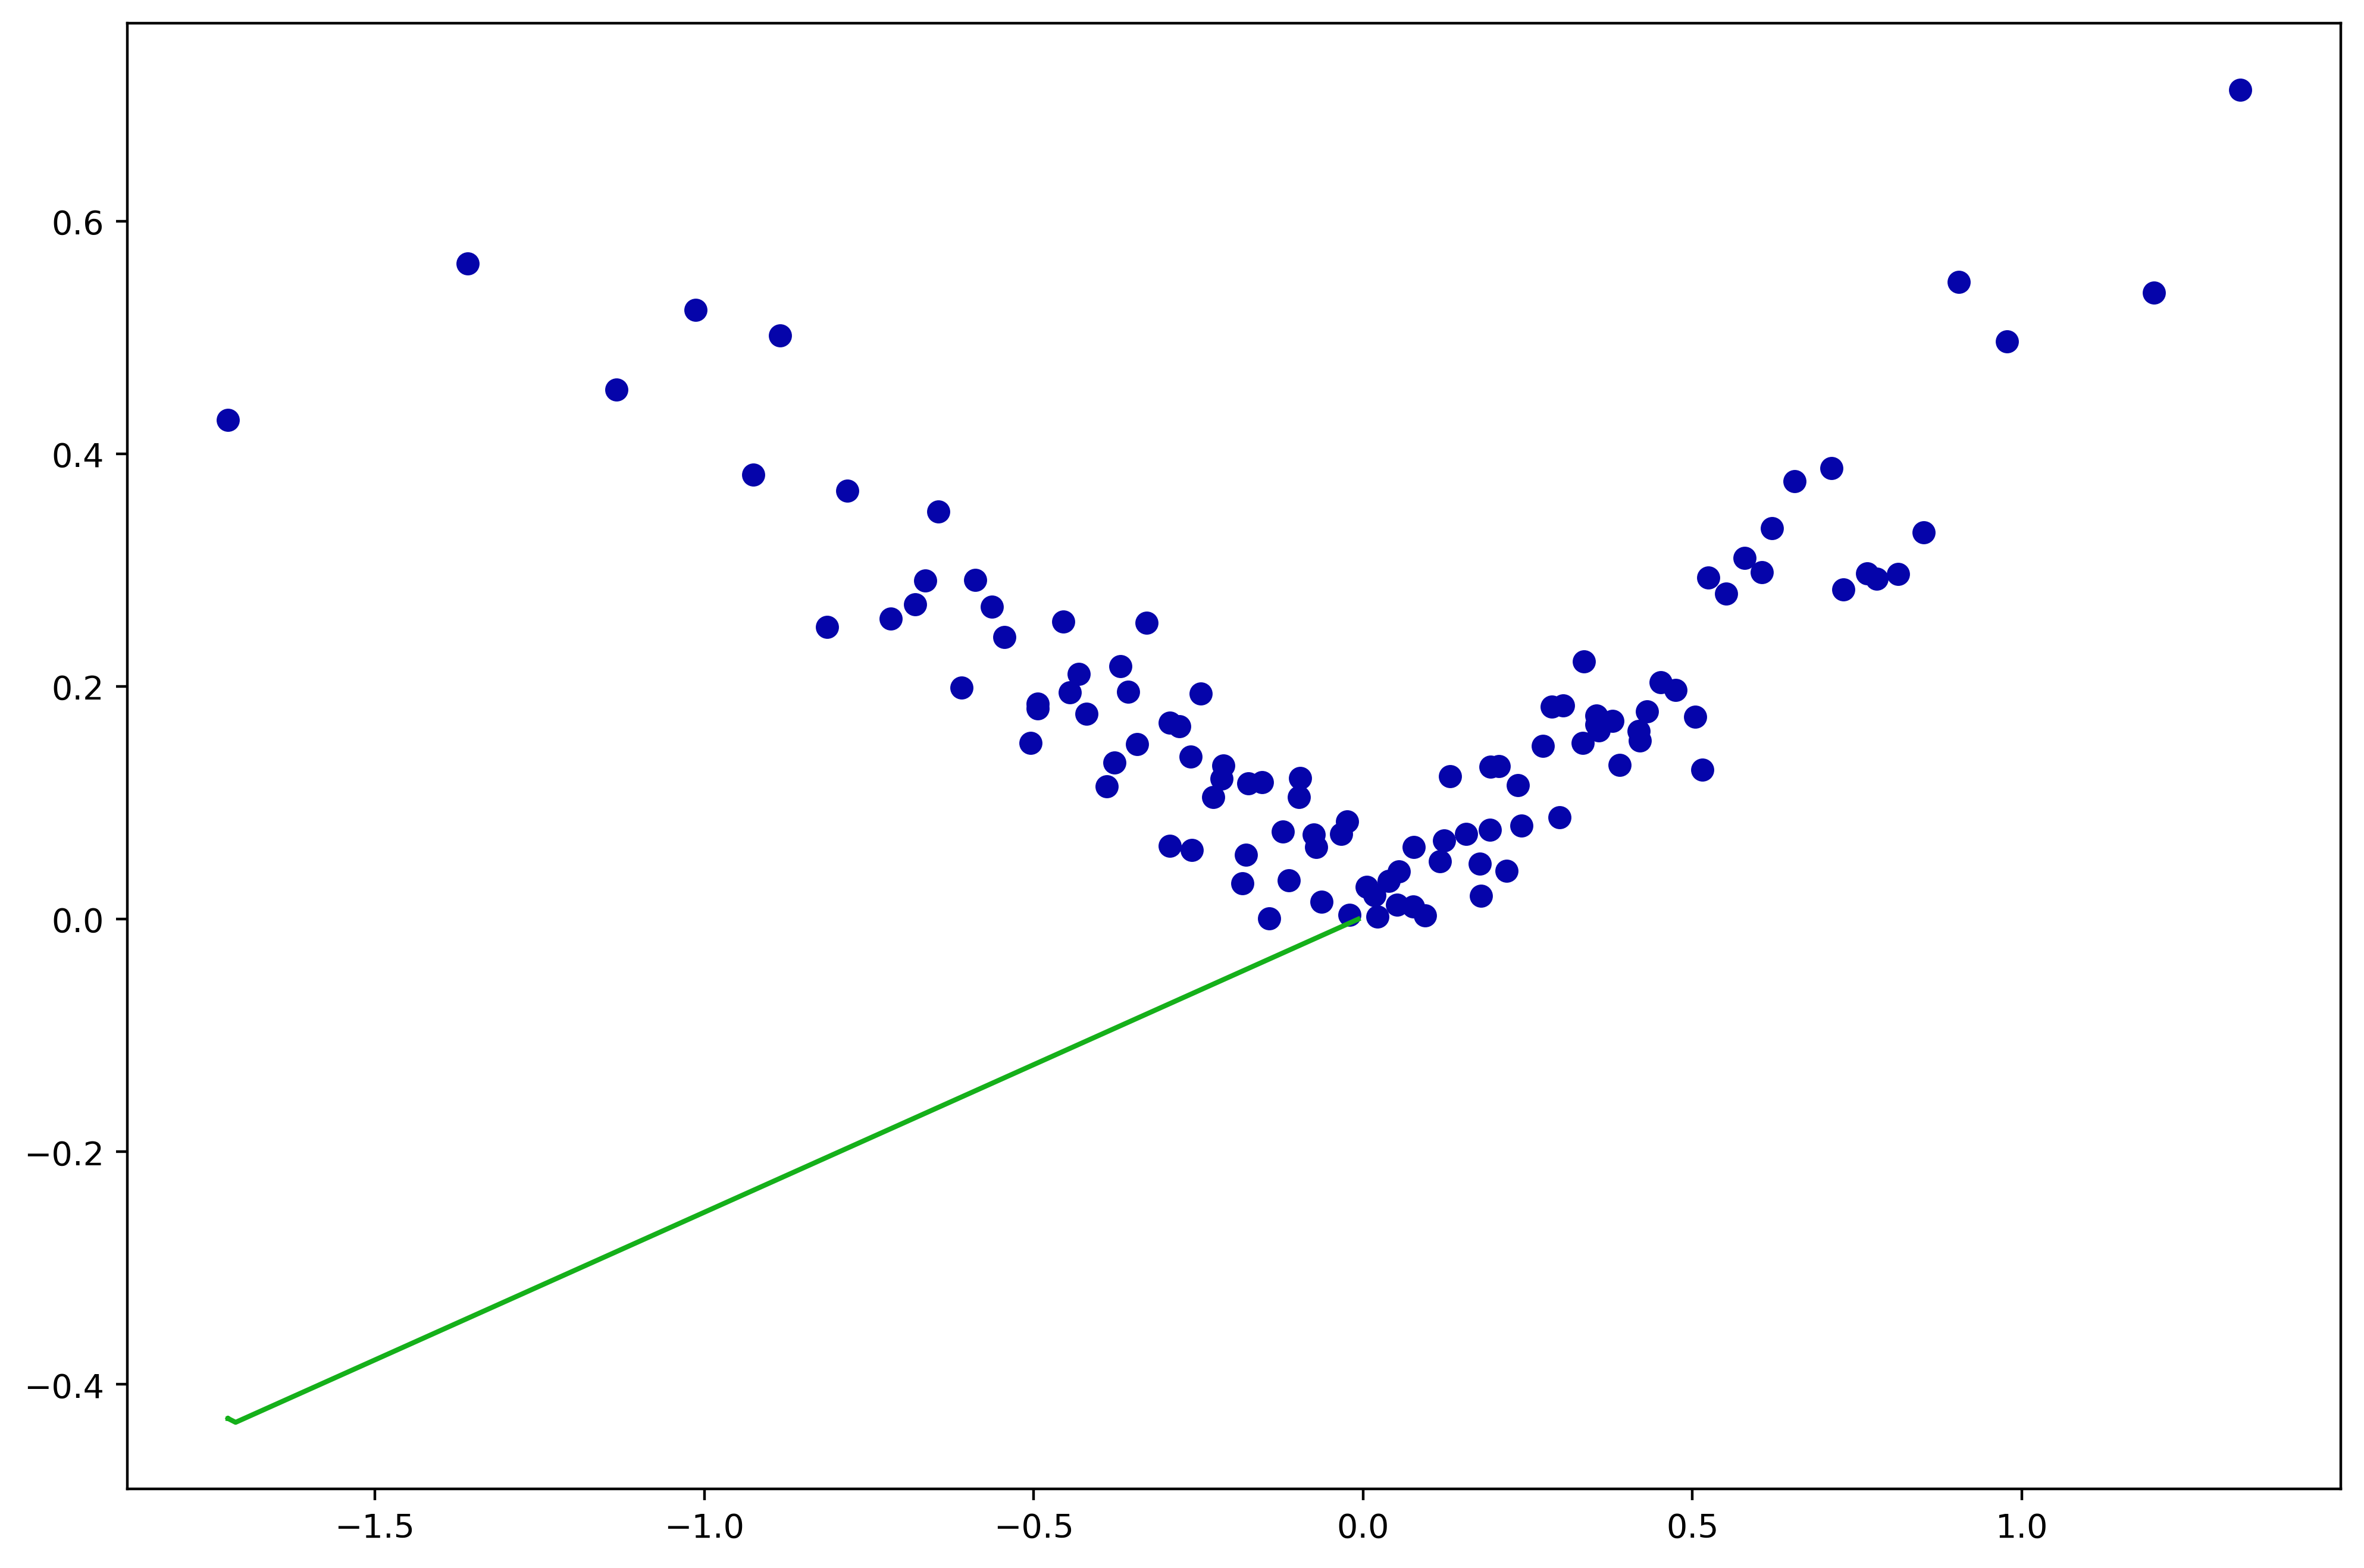

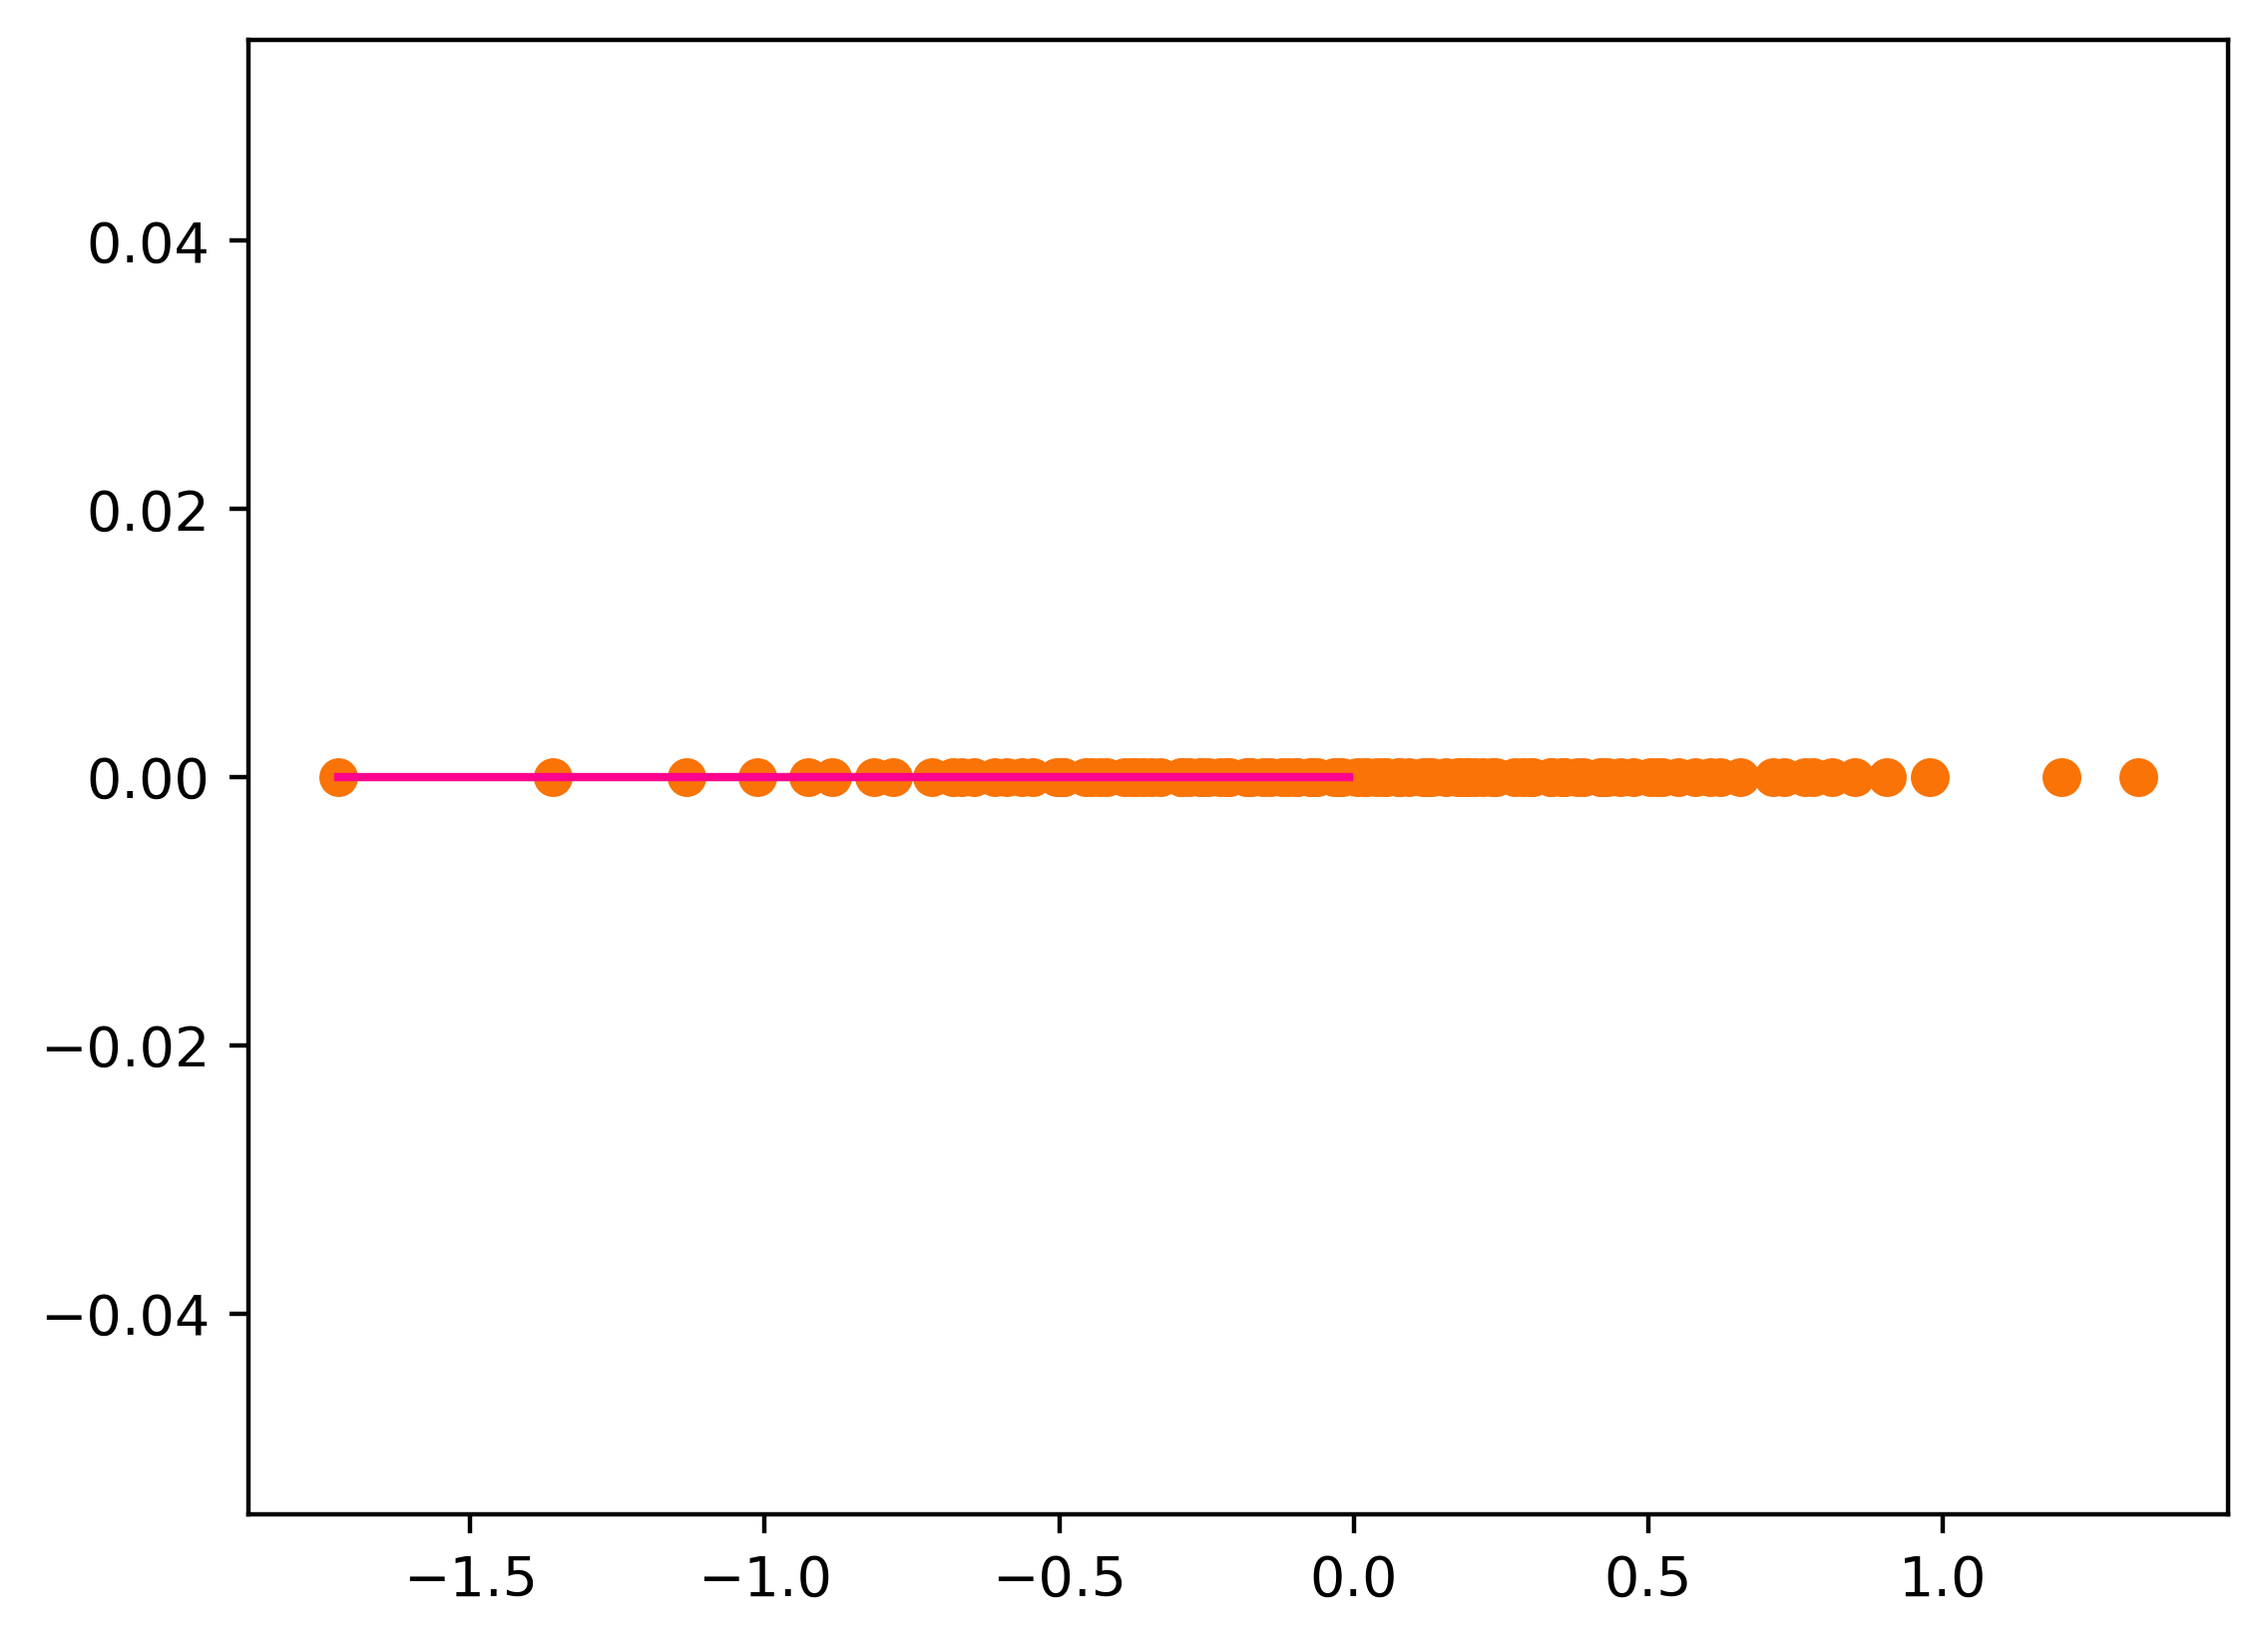

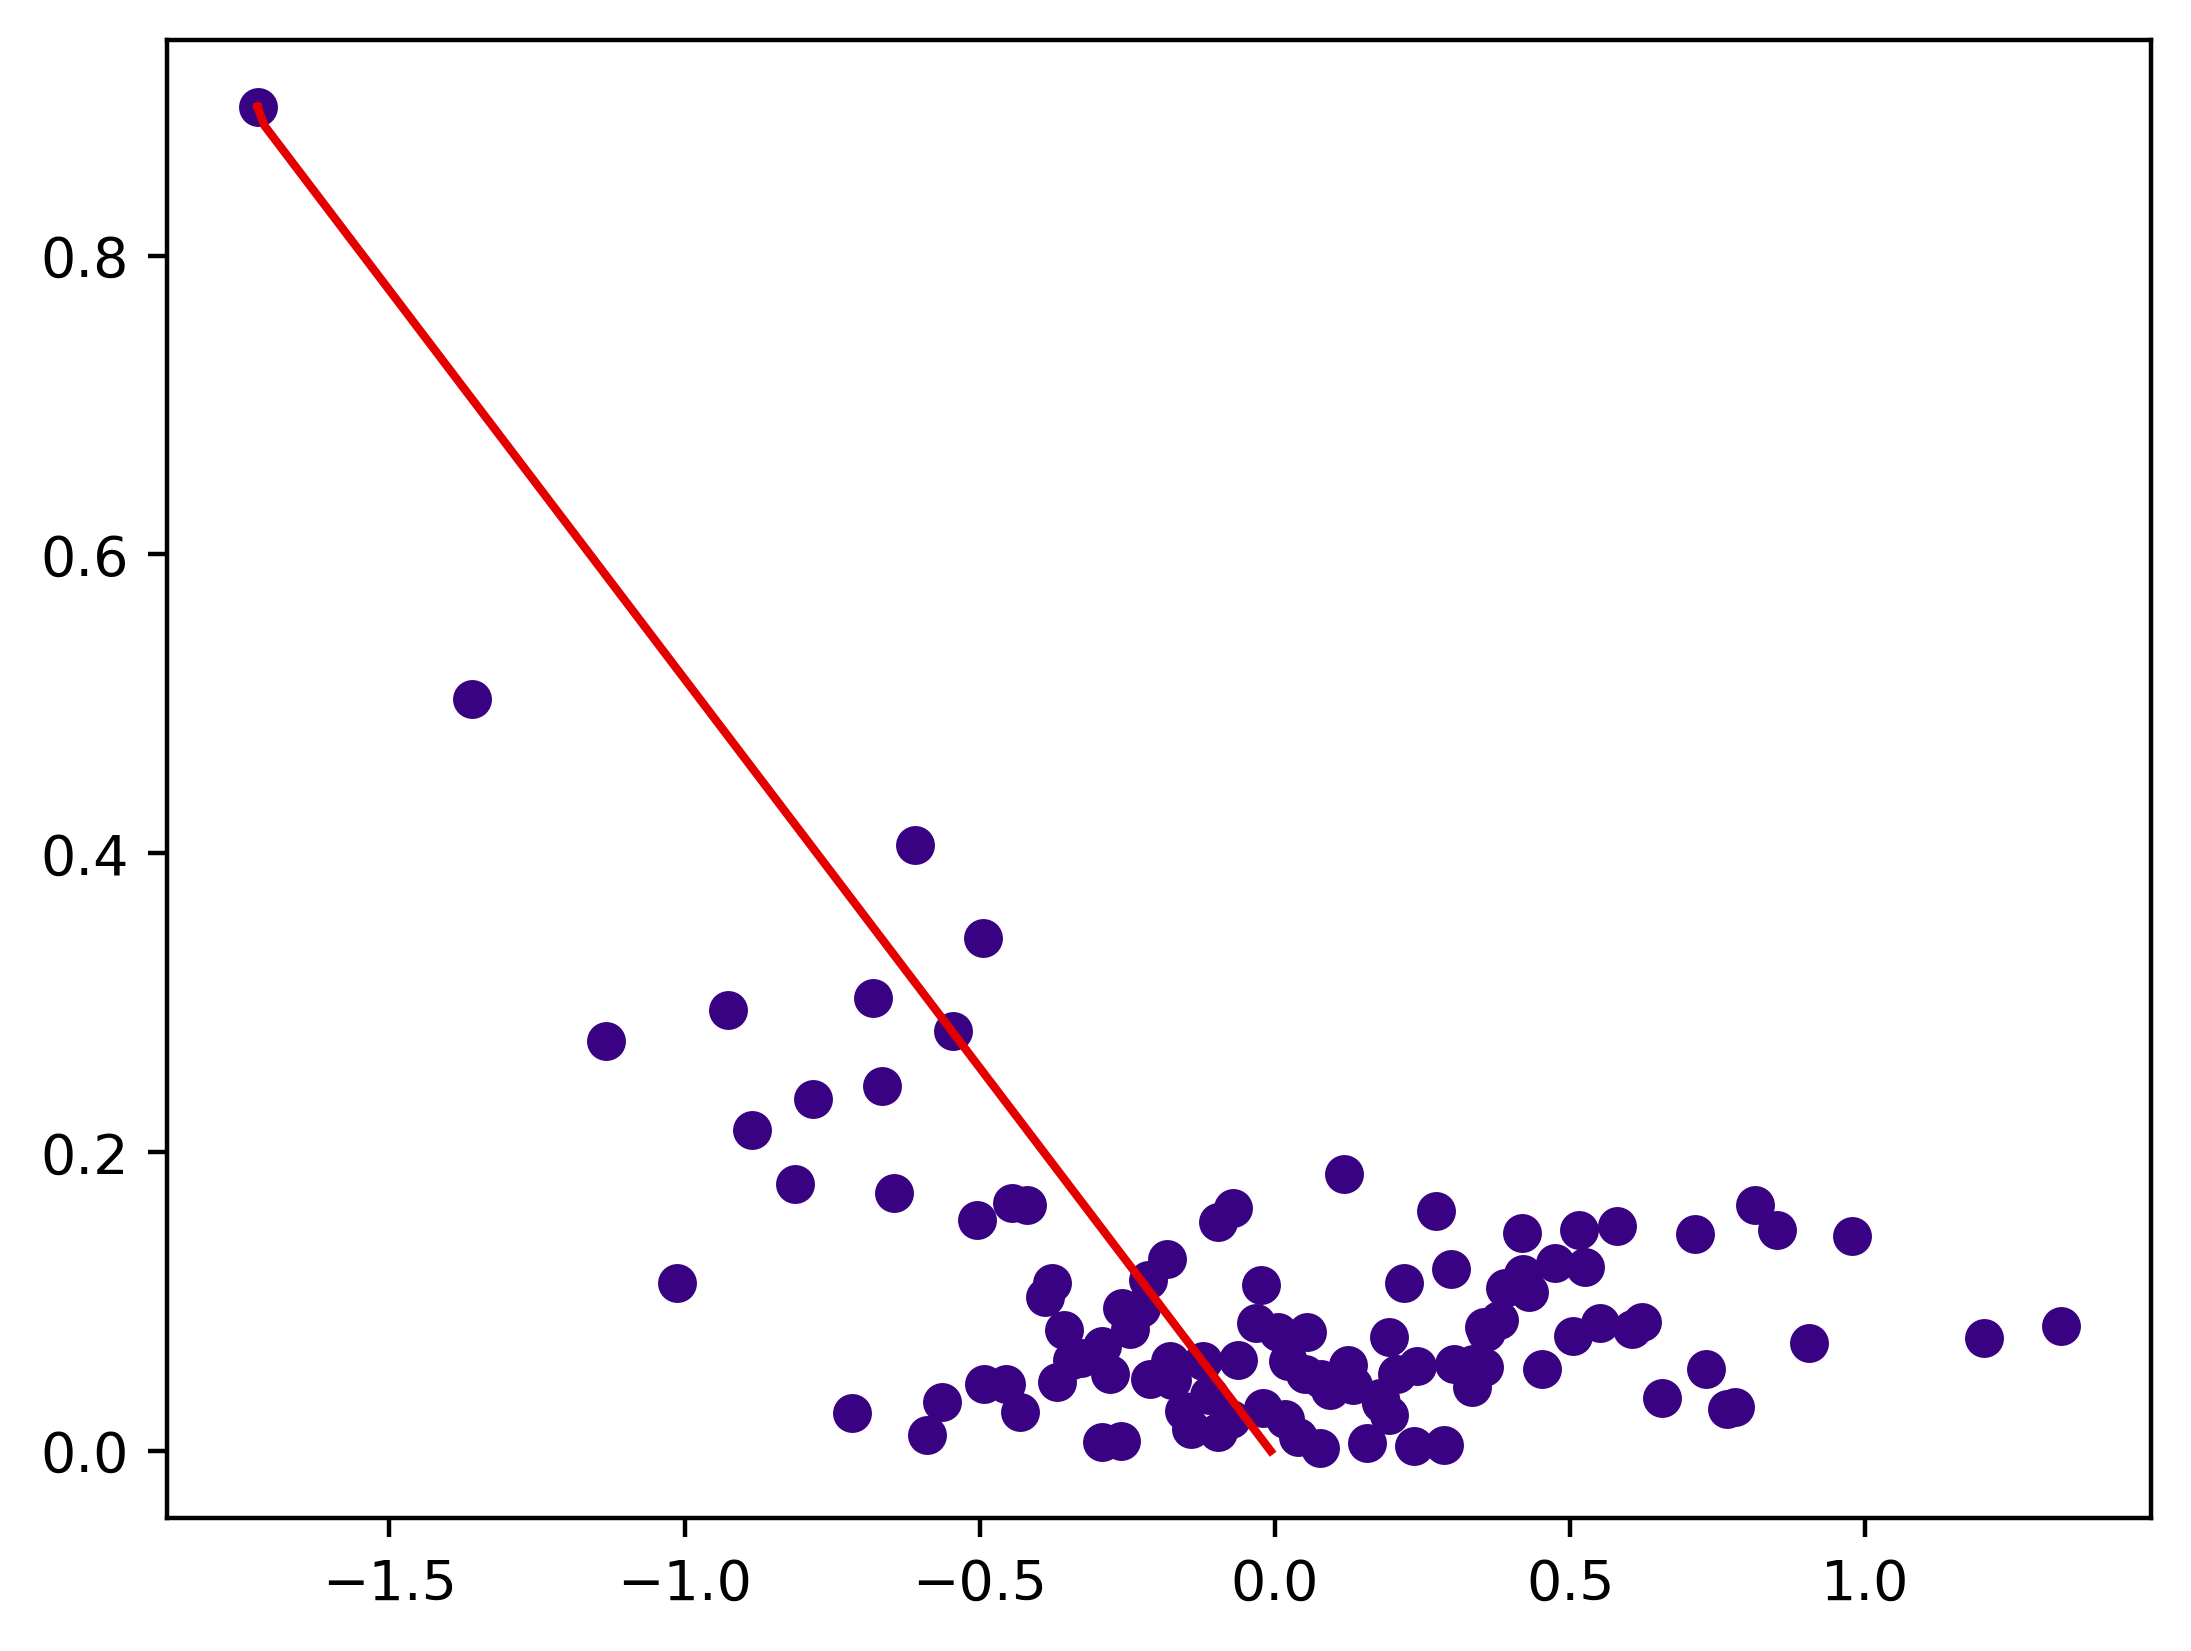

In [22]:
energies = k_zero_eigenvalues / L
observables_x = [abs(np.dot(vec.conj(), sigma_vec('x', vec))) for vec in k_zero_eigenvectors.T]
observables_y = [abs(np.dot(vec.conj(), sigma_vec('y', vec))) for vec in k_zero_eigenvectors.T]
observables_z = [abs(np.dot(vec.conj(), sigma_vec('z', vec))) for vec in k_zero_eigenvectors.T]

plt.figure(figsize=(12, 8))

plt.scatter(energies, observables_x, label='Eigenstates $\sigma^x$', color='xkcd:royal blue')
plt.plot(np.array(thermal_energies) / L, sigma_x_values, label='$\sigma^x(\\beta)$', color='xkcd:green')
plt.show()
plt.scatter(energies, observables_y, label='Eigenstates $\sigma^y$', color='xkcd:orange')
plt.plot(np.array(thermal_energies) / L, sigma_y_values, label='$\sigma^y(\\beta)$', color='xkcd:hot pink')
plt.show()

plt.scatter(energies, observables_z, label='Eigenstates $\sigma^z$', color='xkcd:indigo')
plt.plot(np.array(thermal_energies) / L, sigma_z_values, label='$\sigma^z(\\beta)$', color='xkcd:red')
plt.show()

# plt.xlabel('$\epsilon_n / L$')
# plt.ylabel('$\\langle \sigma^x_1 \\rangle$, $\\langle \sigma^y_1 \\rangle$, $\\langle \sigma^z_1 \\rangle$')
# plt.legend()
# plt.title('Observables vs. Energy/L')
# plt.show()


# Entanglement Entropy

In [24]:
def entanglement_entropy(L, l, coeffs):
    coeffs_matrix = coeffs.reshape(2**l, 2**(L-l))
    s = np.linalg.svd(coeffs_matrix, compute_uv=False)
    lambdas = s**2
    S = -np.sum(lambdas * np.log(lambdas))
    return S

In [ ]:
entropies = {}
for L in Ls:
    k_zero_eigenvalues, k_zero_eigenvectors = k_zero_data[L]
    entropies[L] = [entanglement_entropy(L, L//2, vec) for vec in tqdm(k_zero_eigenvectors.T, desc=f"Computing entanglement entropy for L={L}")]

plt.figure(figsize=(12, 8))
xkcd_colors = ['xkcd:royal blue', 'xkcd:green', 'xkcd:orange', 'xkcd:hot pink', 'xkcd:indigo']

for i, L in enumerate(Ls):
    k_zero_eigenvalues, _ = k_zero_data[L]
    energies = k_zero_eigenvalues / L
    entropies_L = np.array(entropies[L]) / L
    plt.scatter(energies, entropies_L, label=f'L={L}', color=xkcd_colors[i])

plt.xlabel('$\epsilon_n / L$')
plt.ylabel('$S_{L/2} / L$')
plt.legend()
plt.title('Entanglement Entropy vs. Energy Density')
plt.savefig('entropypart2.png', dpi = 400)
plt.show()